# Two layer model

In [1]:
# import modules

from IPython.display import Image
from IPython.display import display

from numpy import *
from matplotlib import pyplot as plt

import os # directory fucntions
import csv # for reading data
from lmfit import minimize, Minimizer, Parameters, Parameter, report_fit # fitting algorithms



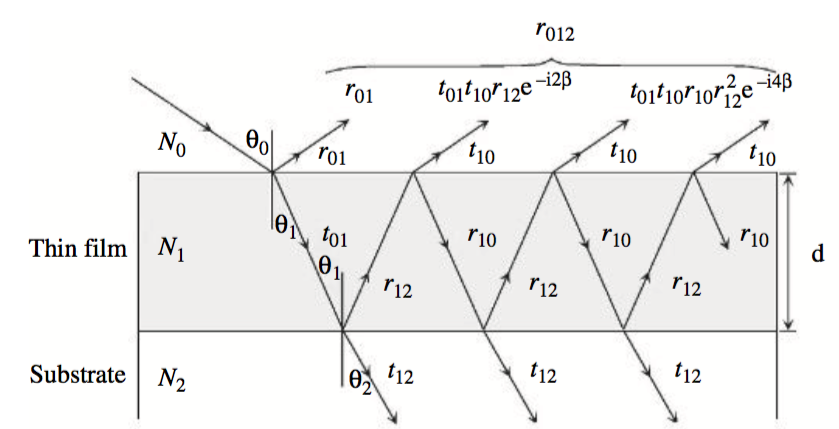

In [2]:
# sketch of our model

Image("ray_paths.png", width=400, unconfined=True)

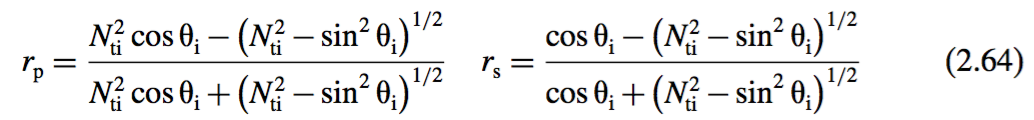

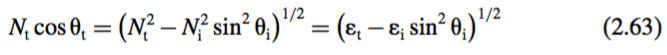

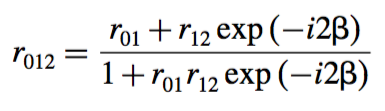

In [3]:
# equations we will work with, from 'Fujiwara H. Spectroscopic ellipsometry'
Image("fresnel_eq.png", width=600, unconfined=True)

eq1 = Image("fresnel_eq.png", width=600, unconfined=True) 
eq2 = Image("Snell_law.png", width=400, unconfined=True)    # from this we calculate angle of transmission at first interface
                                                            #that we need at the second interface
    
eq3 = Image("r_012.png", width=200, unconfined=True) # expression for total complex reflectivity amplitude of two layers

display(eq1, eq2, eq3)

## Fresnel equations for first interface

It works O.o


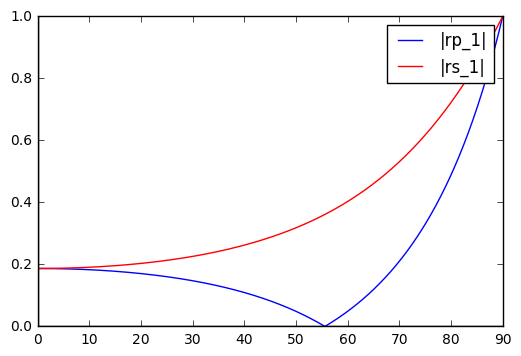

In [4]:
def r01_p(N1, theta_0):

    Nti=N1 # = Nt/Ni
    a= Nti**2 * cos(theta_0) - sqrt(Nti**2 - (sin(theta_0))**2)
    b= Nti**2 * cos(theta_0) + sqrt(Nti**2 - (sin(theta_0))**2)
    return a/b

def r01_s(N1, theta_0):

    Nti=N1 # = Nt/Ni
    a= cos(theta_0) - sqrt(Nti**2 - (sin(theta_0))**2)
    b= cos(theta_0) + sqrt(Nti**2 - (sin(theta_0))**2)
    return a/b

# test plot, rp should go to 0 at Brester angle when N are real numbers, air/glass (n=1.33) interface
n_glass=1.46
angles = linspace(deg2rad(0),deg2rad(90),500)
data_rp = absolute(r01_p(n_glass + 0j, angles)) # interesting: observe how adding absorption (k>0) increases reflectivity at Brewster angle
data_rs = absolute(r01_s(n_glass + 0j, angles))

# test Brewster angle accuracy
max_y = min(data_rp)  # Find the minimum y value
max_x = angles[data_rp.argmin()]  # Find the x value corresponding to the minimum y value
if max_x-arctan(n_glass) < 0.001:
    print('It works O.o')
else:
    print('Yikes')
    
plt.cla()
plt.axis([0,90,0,1])
plt.plot(rad2deg(angles), data_rp,'b-', label='|rp_1|')
plt.plot(rad2deg(angles), data_rs,'r-', label='|rs_1|')


plt.axhline(0, color='black')
plt.axvline(0, color='black')

plt.legend()
plt.show()


## Fresnel equations for second interface

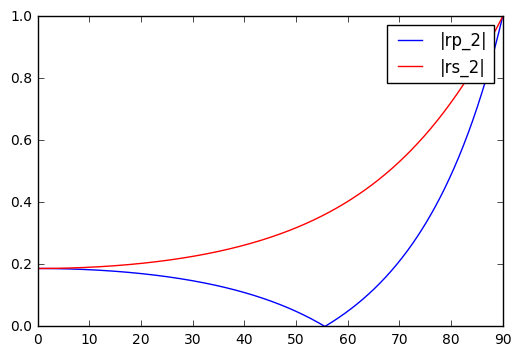

In [5]:
def r12_p(N1, N2, theta_0):
    theta_1 = arccos((1/N1) * sqrt(1 - (1/N1)**2 * (sin(theta_0))**2)) # first interface transmission angle
    #cos_theta_2 = sqrt(1 - (N1/N2)**2 * (sin(theta_1))**2)
    #theta_2 = arccos(cos_theta_2)
    
    Nti=N2/N1 # = Nt/Ni
    a= Nti**2 * cos(theta_1) - sqrt(Nti**2 - (sin(theta_1))**2)
    b= Nti**2 * cos(theta_1) + sqrt(Nti**2 - (sin(theta_1))**2)
    return a/b

def r12_s(N1, N2, theta_0):
    theta_1 = arccos((1/N1) * sqrt(1 - (1/N1)**2 * (sin(theta_0))**2)) # first interface transmission angle

    Nti=N2/N1 # = Nt/Ni
    a= cos(theta_1) - sqrt(Nti**2 - (sin(theta_1))**2)
    b= cos(theta_1) + sqrt(Nti**2 - (sin(theta_1))**2)
    return a/b

# test plot
plt.cla()

angles=linspace(deg2rad(0),deg2rad(90),500)

N1_test = 1.0 + 0.0j
N2_test = 1.46 + 0.0j # test with air/glass interface
plt.axis([0,90,0,1])
plt.plot(rad2deg(angles),absolute(r12_p(N1_test,N2_test, angles)),'b-', label='|rp_2|') # we plot absolute value of COMPLEX reflection amplitude
plt.plot(rad2deg(angles),absolute(r12_s(N1_test,N2_test, angles)),'r-', label='|rs_2|')

plt.legend()
plt.show()

## Fresnel equations for all layers

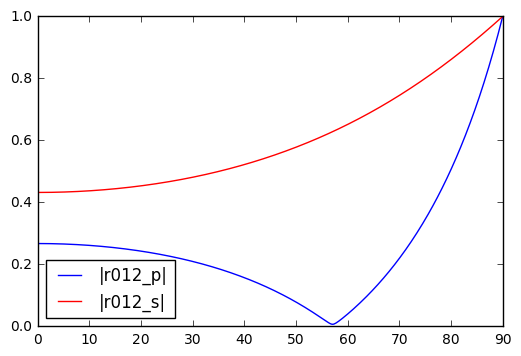

In [6]:
lambd= 658

def r012_p(lamd, d, N1, N2, theta_0):
    beta = ((2*pi*d)/lambd) * sqrt(N1**2 - 1**2 * (sin(theta_0))**2)
    num = r01_p(N1, theta_0) + r12_p(N1,N2, theta_0) * exp(-1j*2*beta)
    denum = 1 + r01_p(N1, theta_0) * r12_p(N1, N2, theta_0) * exp(-1j*2*beta)
    return num/denum

def r012_s(lamd, d, N1, N2, theta_0):
    beta = ((2 * pi * d)/lambd) * sqrt(N1**2 - 1**2 * (sin(theta_0))**2)
    num = r01_s(N1, theta_0) + r12_s(N1, N2, theta_0) * exp(-1j*2*beta)
    denum = 1 + r01_s(N1, theta_0) * r12_s(N1, N2, theta_0) * exp(-1j*2*beta)
    return num/denum

# test plot
plt.cla()

angles=linspace(deg2rad(0),deg2rad(90),500)

plt.axis([0,90,0,1])
plt.plot(rad2deg(angles),absolute(r012_p(lambd, 10, 1.33, 2.1, angles)),'b-', label='|r012_p|')
plt.plot(rad2deg(angles),absolute(r012_s(lambd, 10, 1.33, 2.1, angles)),'r-', label='|r012_s|')
plt.legend(loc='lower left')
plt.show()


In [7]:
lambd = 658 # [nm]

def psi(lamd, d, N1, N2, theta_0):
    rp_abs = absolute(r012_p(lamd, d, N1, N2, theta_0))
    rs_abs = absolute(r012_s(lamd, d, N1, N2, theta_0))
    return arctan2(rp_abs, rs_abs) #see the definition of 'arctan2', it's reverse of 'ordinary' -> arctan2(y,x)

def delta(lamd, d, N1, N2, theta_0):
    rp = r012_p(lamd, d, N1, N2, theta_0)
    rs = r012_s(lamd, d, N1, N2, theta_0)
    return angle(rp/rs)

## Test plots

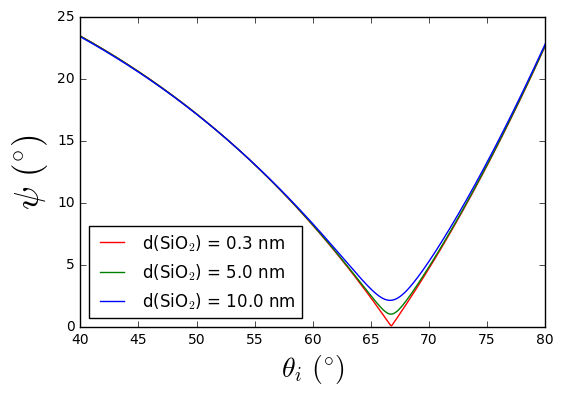

In [8]:
# test plot psi

#     air
#---------------
#    N1: SiO2
#---------------
#  N2: Si wafer

plt.cla()

angles=linspace(deg2rad(40),deg2rad(80),500)

#plt.axis([0,90,-1,1])
N1plot = 1.48 + 0.0j     #SiO2
N2plot = 3.5 + 0.014j      #Si

plt.cla()
plt.plot(rad2deg(angles), rad2deg(psi(lambd, 0.3, N1plot, N2plot, angles)),'r-', label=r'd(SiO$_2$) = 0.3 nm')
plt.plot(rad2deg(angles), rad2deg(psi(lambd, 5., N1plot, N2plot, angles)),'g-', label=r'd(SiO$_2$) = 5.0 nm')
plt.plot(rad2deg(angles), rad2deg(psi(lambd, 10., N1plot, N2plot, angles)),'b-', label=r'd(SiO$_2$) = 10.0 nm')

plt.xlabel(r'$\theta_{i}$ $(^{\circ})$',size=20)
plt.ylabel(r'$\psi$ $(^{\circ})$',size=25,rotation=90)
#plt.title('')

plt.legend(loc='lower left')

plt.savefig("psi_thickness.pdf",bbox_inches='tight')

plt.show()
# As the plot shows the biggest difference in functions when measuring thin film thickness is around the "experimental Brewster angle" of the sample.
# The fit accuracy is therefore determined by the measurements around that point.

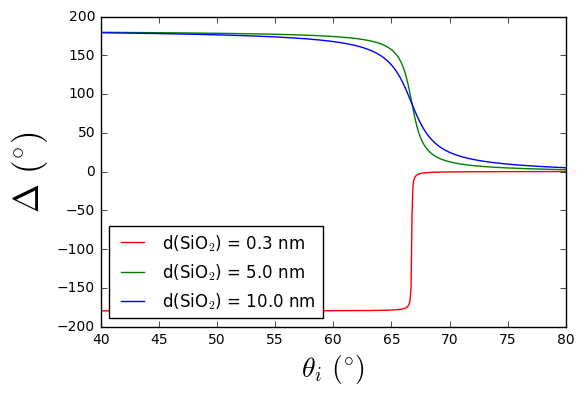

In [22]:
# test plot DELTA
angles=linspace(deg2rad(40),deg2rad(80),500)

#plt.axis([0,90,-1,1])
N1plot = 1.48 + 0.0j     #SiO2
N2plot = 3.5 + 0.014j      #Si

plt.cla()
plt.plot(rad2deg(angles), rad2deg(delta(lambd, 0.3, N1plot, N2plot, angles)),'r-', label=r'd(SiO$_2$) = 0.3 nm')
plt.plot(rad2deg(angles), rad2deg(delta(lambd, 5., N1plot, N2plot, angles)),'g-', label=r'd(SiO$_2$) = 5.0 nm')
plt.plot(rad2deg(angles), rad2deg(delta(lambd, 10., N1plot, N2plot, angles)),'b-', label=r'd(SiO$_2$) = 10.0 nm')

plt.xlabel(r'$\theta_{i}$ $(^{\circ})$',size=20)
plt.ylabel(r'$\Delta$ $(^{\circ})$',size=25,rotation=90)
#plt.title('')

plt.legend(loc='lower left')

plt.savefig("delta_thickness.pdf",bbox_inches='tight')

plt.show()

# Fitting data

In [10]:
print(os.getcwd()) # current working directoy

C:\Users\PCEP3\Desktop\Fizika površin - elipsometrija\Python fitting


## SiO2 / Si wafer

In [9]:
# suggestion: save data as 'tab delimited' in Excel 
data_import=[] 

file_name = 'silicij_test.txt'
with open(file_name) as csvfile:
    readCSV = csv.reader(csvfile, delimiter='\t')
    for row in readCSV:
        data_import.append(row)

print(data_import[0:2]) # print header
data_import.pop(0) # .pop removes the header

# We need data formatted in two arrays: th=[angles] & data=[[delta], [psi] 
theta_data, delta_data, psi_data = [], [], []

for line in data_import:
    theta_data.append(deg2rad(float(line[0]))) # be careful with deg and rad conversion!
    delta_data.append(deg2rad(float(line[1])))
    psi_data.append(deg2rad(float(line[2])))

#   data[delta,psi]
data = append(delta_data, psi_data)

print(psi_data)
print(data)

#print(data)

[['AOI', 'delta ', 'psi'], ['45', '170.3402813', '34.43378125']]
[0.60098285672398877, 0.5912002862665604, 0.58103810669682354, 0.57046250226052031, 0.55947456378843363, 0.54799793312578837, 0.53606315353449463, 0.52366477086063989, 0.51068061205658466, 0.49714776536893357, 0.48303841461273317, 0.46833347024928967, 0.45297511824713083, 0.43695844986773535, 0.4202692843109308, 0.40285907960689615, 0.38477583231006113, 0.36598899915851596, 0.34650457972156423, 0.32692510214863313, 0.30563605903994329, 0.28449084973664074]
[ 2.97299876  2.97337509  2.97455428  2.97665413  2.97971337  2.98384271
  2.9891376   2.99568586  3.00361783  3.01319914  3.02440798  3.03753394
  3.05275703  3.07037613  3.09058977  3.11391609  3.14074835  3.17179067
  3.20759064  3.25224528  3.29811651  3.35570965  0.60098286  0.59120029
  0.58103811  0.5704625   0.55947456  0.54799793  0.53606315  0.52366477
  0.51068061  0.49714777  0.48303841  0.46833347  0.45297512  0.43695845
  0.42026928  0.40285908  0.38477583

In [36]:
lamd = 658 #nm


def fcn2min(params, theta_data, data):
    n1 = params['n1']
    k1 = params['k1']
    n2 = params['n2']
    k2 = params['k2']
    d = params['d']

    # model - data
    residual_psi = psi(lamd, d, n1 + 1j*k1, n2 + 1j*k2, theta_data) - psi_data
    return residual_psi


# create a set of Parameters
params = Parameters()
params.add('n1', value= 1.480, min=1., max=1.8, vary=True)
params.add('k1', value= 0., min=0., vary=True)
params.add('n2', value= 3.840, min=3.4,vary=True)#, min=3.00, max=6.00)
params.add('k2', value= 0.014, min=0.01,max=0.03, vary=True)#, max= 1)
params.add('d', value= 0.27, min=0.2, max=0.6, vary=True)#, min=0.02, max=0.04)

# do fit, here with LEASTSQ method
minner_leastsq = Minimizer(fcn2min, params, fcn_args=(theta_data, psi_data))
#kws = {'options': {'maxiter':50}}
result_leastsq = minner_leastsq.minimize()
# calculate final result
final_leastsq = psi_data + result_leastsq.residual

# do fit, here with NELDER method
minner_nelder = Minimizer(fcn2min, params, fcn_args=(theta_data, psi_data))
#kws = {'options': {'maxiter':50}}
result_nelder = minner_nelder.minimize(method= 'nelder')
# calculate final result
final_nelder = psi_data + result_nelder.residual


# write error report
print("LEASTSQ REPORT")
report_fit(result_leastsq)
print("\n \n")
print("NELDER REPORT")
report_fit(result_nelder)

LEASTSQ REPORT
[[Fit Statistics]]
    # function evals   = 3141
    # data points      = 22
    # variables        = 5
    chi-square         = 0.000
    reduced chi-square = 0.000
    Akaike info crit   = -301.043
    Bayesian info crit = -295.588
[[Variables]]
    n1:   1.00000008 +/- nan      (nan%) (init= 1.48)
    k1:   0          +/- nan      (nan%) (init= 0)
    n2:   3.83911086 +/- nan      (nan%) (init= 3.84)
    k2:   0.02999997 +/- nan      (nan%) (init= 0.014)
    d:    0.20000018 +/- nan      (nan%) (init= 0.27)
[[Correlations]] (unreported correlations are <  0.100)

 

NELDER REPORT
[[Fit Statistics]]
    # function evals   = 379
    # data points      = 22
    # variables        = 5
    chi-square         = 0.000
    reduced chi-square = 0.000
    Akaike info crit   = -301.038
    Bayesian info crit = -295.582
[[Variables]]
    n1:   1          (init= 1.48)
    k1:   5.7506e-05 (init= 0)
    n2:   3.83937313 (init= 3.84)
    k2:   0.01003898 (init= 0.014)
    d:    0.54

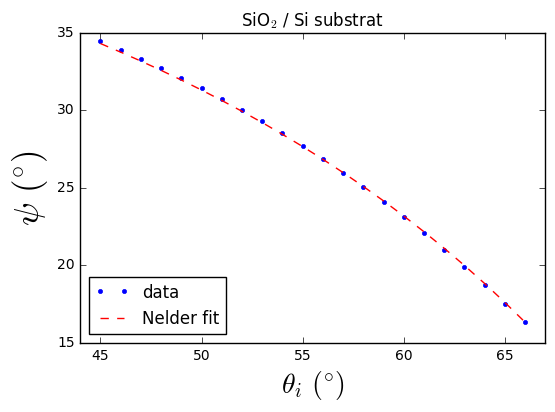

In [30]:
# plot results
plt.cla()
plt.plot(rad2deg(theta_data), rad2deg(psi_data),'b.', label='data')
#plt.plot(rad2deg(theta_data), final_leastsq, 'r-', label='leastsq')
plt.plot(rad2deg(theta_data), rad2deg(final_nelder), 'r--', label='Nelder fit')
plt.legend(loc='lower left')

plt.xlim(44,67)

#plt.setp(fig,lw=2.5)
plt.xlabel(r'$\theta_{i}$ $(^{\circ})$',size=20)
plt.ylabel(r'$\psi$ $(^{\circ})$',size=25,rotation=90)
plt.title('SiO$_2$ / Si substrat')

#plt.savefig("psi_fit_Si.pdf",bbox_inches='tight')

plt.show()

## LSAT substrat

In [29]:
# suggestion: save data as 'tab delimited' in Excel 
data_import=[] 

file_name = 'LSAT.txt'
with open(file_name) as csvfile:
    readCSV = csv.reader(csvfile, delimiter='\t')
    for row in readCSV:
        data_import.append(row)

print(data_import[0]) # print header
data_import.pop(0) # .pop removes the header

# We need data formatted in two arrays: th=[angles] & data=[[delta], [psi] 
theta_data, delta_data, psi_data, psierr_data, deltaerr_data = [], [], [], [], []

for line in data_import:
    theta_data.append(deg2rad(float(line[1]))) # be careful with deg and rad conversion!
    psi_data.append(deg2rad(float(line[2])))
    psierr_data.append(1/(deg2rad(float(line[3])))**2)
    delta_data.append(deg2rad(float(line[4])))
    deltaerr_data.append(deg2rad(float(line[5])))

psierr_data = asarray(psierr_data)
psierr_data = psierr_data/psierr_data.max()

deltaerr_data = asarray(deltaerr_data)
deltaerr_data = deltaerr_data/deltaerr_data.max()
# asarray() converts to numpy array - needed for weighting, as matehmatical operations don't work on lists
print(psierr_data)
print(deltaerr_data)



['lambda (nm)', 'AOI', 'PSI AVG', 'PSI ERR', 'DELTA AVG', 'DELTA ERR']
[ 1.          0.94086369  0.87437514  0.86121799  0.80968831  0.79736724
  0.743499    0.45810776  0.68906288  0.65636124  0.63713176  0.61381053
  0.58205106  0.57428136  0.60292398  0.54990334  0.57321743  0.54289049
  0.20479733  0.4536943   0.29580913  0.49024603]
[ 0.0164578   0.00843989  0.00899387  0.00843295  0.00834275  0.00841322
  0.00811409  0.02209624  0.00853822  0.00908493  0.00943087  0.01062297
  0.01093179  0.01432187  0.01743462  0.04871829  0.0371417   0.08521282
  0.58483964  1.          0.1145892   0.14275803]


In [30]:
lamd = 658 #nm
#fit SUBSTRATE -> n1=n2, k1=k2

def fcn2min(params, theta_data, data): 
    n1  = params['n1']
    k1  = params['k1']
    d   = params['d']
    
    # model - data
    residual_psi = psi(lamd, d, n1 + 1j*k1, n1 + 1j*k1, theta_data) - psi_data
    weighted = (asarray(residual_psi))**2 * psierr_data #psierr_data was already squared and inversed!
    return weighted.tolist()

# create a set of Parameters
params = Parameters()
params.add('n1',   value= 1.8, min = 1.0)
params.add('k1',   value= 0.000,  min = 0, vary=True)
params.add('d',    value= 0, vary=False)#,  min=0.02, max=0.04)


# do fit, here with LEASTSQ method
minner_leastsq = Minimizer(fcn2min, params, fcn_args=(theta_data, psi_data))
#kws  = {'options': {'maxiter':50}}
result_leastsq = minner_leastsq.minimize()
# calculate final result
final_leastsq = psi_data + result_leastsq.residual


# do fit, here with NELDER method
minner_nelder = Minimizer(fcn2min, params, fcn_args=(theta_data, psi_data))
#kws  = {'options': {'maxiter':50}}
result_nelder = minner_nelder.minimize(method= 'nelder')
# calculate final result
final_nelder = psi_data + result_nelder.residual

# write error report
print("LEASTSQ REPORT")
report_fit(result_leastsq)
print("\n \n")
print("NELDER REPORT")
report_fit(result_nelder)

LEASTSQ REPORT
[[Fit Statistics]]
    # function evals   = 54
    # data points      = 22
    # variables        = 2
    chi-square         = 0.000
    reduced chi-square = 0.000
    Akaike info crit   = -532.269
    Bayesian info crit = -530.087
[[Variables]]
    n1:   2.02000403 +/- nan      (nan%) (init= 1.8)
    k1:   0          +/- nan      (nan%) (init= 0)
    d:    0 (fixed)
[[Correlations]] (unreported correlations are <  0.100)

 

NELDER REPORT
[[Fit Statistics]]
    # function evals   = 40
    # data points      = 22
    # variables        = 2
    chi-square         = 0.000
    reduced chi-square = 0.000
    Akaike info crit   = -532.269
    Bayesian info crit = -530.086
[[Variables]]
    n1:   2.01997567 (init= 1.8)
    k1:   8.6992e-09 (init= 0)
    d:    0 (fixed)
[[Correlations]] (unreported correlations are <  0.100)


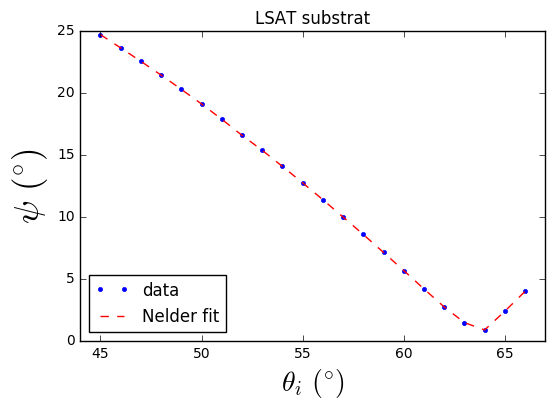

In [31]:
# plot results
plt.cla()
plt.plot(rad2deg(theta_data), rad2deg(psi_data),'b.', label='data')
#plt.plot(rad2deg(theta_data), final_leastsq, 'r-', label='leastsq')
plt.plot(rad2deg(theta_data), rad2deg(final_nelder), 'r--', label='Nelder fit')
plt.legend(loc='lower left')

plt.xlim(44,67)

#plt.setp(fig,lw=2.5)
plt.xlabel(r'$\theta_{i}$ $(^{\circ})$',size=20)
plt.ylabel(r'$\psi$ $(^{\circ})$',size=25,rotation=90)
plt.title('LSAT substrat')

plt.savefig("psi_fit_LSAT.pdf",bbox_inches='tight')

plt.show()

Nafitaj še substrat MgO, nato pa vzorca 1 in 2

## MgO substrat

In [85]:
# suggestion: save data as 'tab delimited' in Excel 
data_import=[] 

file_name = 'MgO.txt'
with open(file_name) as csvfile:
    readCSV = csv.reader(csvfile, delimiter='\t')
    for row in readCSV:
        data_import.append(row)

print(data_import[0]) # print header
data_import.pop(0) # .pop removes the header

# We need data formatted in two arrays: th=[angles] & data=[[delta], [psi] 
theta_data, delta_data, psi_data, psierr_data, deltaerr_data = [], [], [], [], []

for line in data_import:
    theta_data.append(deg2rad(float(line[1]))) # be careful with deg and rad conversion!
    psi_data.append(deg2rad(float(line[2])))
    psierr_data.append(1/(deg2rad(float(line[3])))**2)
    delta_data.append(deg2rad(float(line[4])))
    deltaerr_data.append(deg2rad(float(line[5])))

psierr_data = asarray(psierr_data)
psierr_data = psierr_data/psierr_data.max()

deltaerr_data = asarray(deltaerr_data)
deltaerr_data = deltaerr_data/deltaerr_data.max()
# asarray() converts to numpy array - needed for weighting, as matehmatical operations don't work on lists
print(psierr_data)
print(deltaerr_data)



['lambda', 'AOI', 'PSI AVG', 'PSI ERR', 'DELTA AVG', 'DELTA ERR']
[ 0.36775693  0.4262871   0.39275251  0.53488152  0.44515744  0.33925069
  0.37000211  0.43850554  0.3566119   0.35436592  0.36845562  0.31101708
  0.36119015  0.32871494  0.00506091  0.02815508  0.16618123  0.38526715
  0.26496528  0.57380321  0.79436798  1.        ]
[ 0.00765082  0.00813836  0.00736595  0.0091256   0.00895063  0.01123587
  0.01201085  0.01101618  0.01522827  0.016627    0.02225093  0.05317766
  0.06307791  0.14918638  1.          0.68163609  0.29092997  0.07370102
  0.03166415  0.01602345  0.01082417  0.00891511]


In [86]:
lamd = 658 #nm
#fit SUBSTRATE -> n1=n2, k1=k2

def fcn2min(params, theta_data, data): 
    n1  = params['n1']
    k1  = params['k1']
    d   = params['d']
    
    # model - data
    residual_psi = psi(lamd, d, n1 + 1j*k1, n1 + 1j*k1, theta_data) - psi_data
    weighted = (asarray(residual_psi))**2 * psierr_data #psierr_data was already squared and inversed!
    return weighted.tolist()

# create a set of Parameters
params = Parameters()
params.add('n1',   value= 1.8, min = 1.0)
params.add('k1',   value= 0.000,  min = 0, vary=True)
params.add('d',    value= 0, vary=False)#,  min=0.02, max=0.04)


# do fit, here with LEASTSQ method
minner_leastsq = Minimizer(fcn2min, params, fcn_args=(theta_data, psi_data))
#kws  = {'options': {'maxiter':50}}
result_leastsq = minner_leastsq.minimize()
# calculate final result
final_leastsq = psi_data + result_leastsq.residual


# do fit, here with NELDER method
minner_nelder = Minimizer(fcn2min, params, fcn_args=(theta_data, psi_data))
#kws  = {'options': {'maxiter':50}}
result_nelder = minner_nelder.minimize(method= 'nelder')
# calculate final result
final_nelder = psi_data + result_nelder.residual

# write error report
print("LEASTSQ REPORT")
report_fit(result_leastsq)
print("\n \n")
print("NELDER REPORT")
report_fit(result_nelder)

LEASTSQ REPORT
[[Fit Statistics]]
    # function evals   = 51
    # data points      = 22
    # variables        = 2
    chi-square         = 0.000
    reduced chi-square = 0.000
    Akaike info crit   = -591.911
    Bayesian info crit = -589.729
[[Variables]]
    n1:   1.71713522 +/- nan      (nan%) (init= 1.8)
    k1:   0          +/- nan      (nan%) (init= 0)
    d:    0 (fixed)
[[Correlations]] (unreported correlations are <  0.100)

 

NELDER REPORT
[[Fit Statistics]]
    # function evals   = 38
    # data points      = 22
    # variables        = 2
    chi-square         = 0.000
    reduced chi-square = 0.000
    Akaike info crit   = -591.911
    Bayesian info crit = -589.729
[[Variables]]
    n1:   1.71713945 (init= 1.8)
    k1:   2.2377e-07 (init= 0)
    d:    0 (fixed)
[[Correlations]] (unreported correlations are <  0.100)


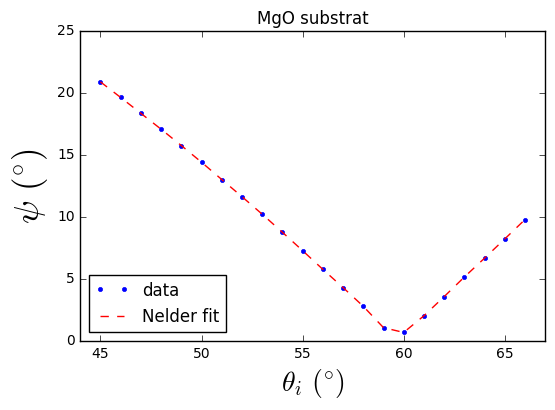

In [87]:
# plot results
plt.cla()
plt.plot(rad2deg(theta_data), rad2deg(psi_data),'b.', label='data')
#plt.plot(rad2deg(theta_data), final_leastsq, 'r-', label='leastsq')
plt.plot(rad2deg(theta_data), rad2deg(final_nelder), 'r--', label='Nelder fit')
plt.legend(loc='lower left')

plt.xlim(44,67)

#plt.setp(fig,lw=2.5)
plt.xlabel(r'$\theta_{i}$ $(^{\circ})$',size=20)
plt.ylabel(r'$\psi$ $(^{\circ})$',size=25,rotation=90)
plt.title('MgO substrat')

plt.savefig("psi_fit_MgO.pdf",bbox_inches='tight')

plt.show()

## Sample 1

In [80]:
# suggestion: save data as 'tab delimited' in Excel 
data_import=[] 

file_name = 'sample_1.txt'
with open(file_name) as csvfile:
    readCSV = csv.reader(csvfile, delimiter='\t')
    for row in readCSV:
        data_import.append(row)

print(data_import[0]) # print header
data_import.pop(0) # .pop removes the header

# We need data formatted in two arrays: th=[angles] & data=[[delta], [psi] 
theta_data, delta_data, psi_data, psierr_data, deltaerr_data = [], [], [], [], []

for line in data_import:
    theta_data.append(deg2rad(float(line[1]))) # be careful with deg and rad conversion!
    psi_data.append(deg2rad(float(line[2])))
    psierr_data.append(1/(deg2rad(float(line[3])))**2)
    delta_data.append(deg2rad(float(line[4])))
    deltaerr_data.append(deg2rad(float(line[5])))

psierr_data = asarray(psierr_data)
psierr_data = psierr_data/psierr_data.max()

deltaerr_data = asarray(deltaerr_data)
deltaerr_data = deltaerr_data/deltaerr_data.max()
# asarray() converts to numpy array - needed for weighting, as matehmatical operations don't work on lists
print(psierr_data)
print(deltaerr_data)



['lambda', 'AOI', 'psi ', 'psi err', 'delta ', 'delta err']
[ 0.35761605  0.33321855  0.33957871  0.36897403  0.37900214  0.41425214
  0.4124767   0.45071846  0.51277434  0.53353842  0.52502807  0.68017717
  0.56084642  0.53667445  0.4567577   0.47569665  0.29656635  1.
  0.87572767  0.92724222  0.96046871  0.93227606]
[ 0.00629146  0.00641591  0.00626861  0.0063548   0.00747582  0.00737284
  0.00835657  0.00804459  0.01040813  0.01154367  0.01377209  0.0179682
  0.03325561  0.07032895  0.34632068  1.          0.50258496  0.06950287
  0.03180893  0.02074796  0.01425207  0.01131749]


In [81]:
lamd = 658 #nm

def fcn2min(params, theta_data, data): 
    n1  = params['n1']
    k1  = params['k1']
    n2  = params['n2']
    k2  = params['k2']
    d   = params['d']
    
    # model - data
    residual_psi = psi(lamd, d, n1 + 1j*k1, n2 + 1j*k2, theta_data) - psi_data
    weighted = (asarray(residual_psi))**2 * psierr_data #psierr_data was already squared and inversed!
    return weighted.tolist()

# create a set of Parameters
params = Parameters()
params.add('n1',   value= 1.8, min = 1.3)
params.add('k1',   value= 0.,  min = 0, vary=True)
params.add('n2',   value= 1.72, vary=False)
params.add('k2',   value= 0.,  min = 0, vary=False)
params.add('d',    value= 0,  min = 2.8, max = 3.2)#,  min=0.02, max=0.04)


# do fit, here with LEASTSQ method
minner_leastsq = Minimizer(fcn2min, params, fcn_args=(theta_data, psi_data),xtol= 1.e-9,ftol= 1.e-9)
#kws  = {'options': {'maxiter':50}}
result_leastsq = minner_leastsq.minimize()
# calculate final result
final_leastsq = psi_data + result_leastsq.residual


# do fit, here with NELDER method
minner_nelder = Minimizer(fcn2min, params, fcn_args=(theta_data, psi_data))
#kws  = {'options': {'maxiter':50}}
result_nelder = minner_nelder.minimize(method= 'nelder')
# calculate final result
final_nelder = psi_data + result_nelder.residual

# write error report
print("LEASTSQ REPORT")
report_fit(result_leastsq)
print("\n \n")
print("NELDER REPORT")
report_fit(result_nelder)

LEASTSQ REPORT
[[Fit Statistics]]
    # function evals   = 87
    # data points      = 22
    # variables        = 3
    chi-square         = 0.000
    reduced chi-square = 0.000
    Akaike info crit   = -561.764
    Bayesian info crit = -558.491
[[Variables]]
    n1:   1.72531434 +/- nan      (nan%) (init= 1.8)
    k1:   0          +/- nan      (nan%) (init= 0)
    n2:   1.72 (fixed)
    k2:   0 (fixed)
    d:    2.80000000 +/- nan      (nan%) (init= 2.8)
[[Correlations]] (unreported correlations are <  0.100)

 

NELDER REPORT
[[Fit Statistics]]
    # function evals   = 70
    # data points      = 22
    # variables        = 3
    chi-square         = 0.000
    reduced chi-square = 0.000
    Akaike info crit   = -561.763
    Bayesian info crit = -558.490
[[Variables]]
    n1:   1.72531908 (init= 1.8)
    k1:   7.4280e-09 (init= 0)
    n2:   1.72 (fixed)
    k2:   0 (fixed)
    d:    2.80126313 (init= 2.8)
[[Correlations]] (unreported correlations are <  0.100)


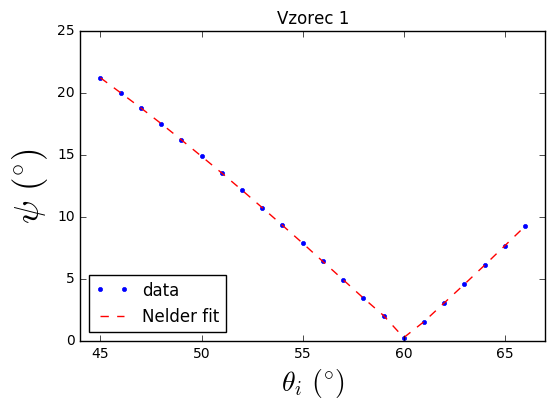

In [82]:
# plot results
plt.cla()
plt.plot(rad2deg(theta_data), rad2deg(psi_data),'b.', label='data')
#plt.plot(rad2deg(theta_data), final_leastsq, 'r-', label='leastsq')
plt.plot(rad2deg(theta_data), rad2deg(final_nelder), 'r--', label='Nelder fit')
plt.legend(loc='lower left')

plt.xlim(44,67)

#plt.setp(fig,lw=2.5)
plt.xlabel(r'$\theta_{i}$ $(^{\circ})$',size=20)
plt.ylabel(r'$\psi$ $(^{\circ})$',size=25,rotation=90)
plt.title('Vzorec 1')

plt.savefig("psi_fit_sample_1.pdf",bbox_inches='tight')

plt.show()

## Sample 2: TaS2 / LSAT

In [65]:
# suggestion: save data as 'tab delimited' in Excel 
data_import=[] 

file_name = 'sample_2.txt'
with open(file_name) as csvfile:
    readCSV = csv.reader(csvfile, delimiter='\t')
    for row in readCSV:
        data_import.append(row)

print(data_import[0]) # print header
data_import.pop(0) # .pop removes the header

# We need data formatted in two arrays: th=[angles] & data=[[delta], [psi] 
theta_data, delta_data, psi_data, psierr_data, deltaerr_data = [], [], [], [], []

for line in data_import:
    theta_data.append(deg2rad(float(line[0]))) # be careful with deg and rad conversion!
    psi_data.append(deg2rad(float(line[1])))
    psierr_data.append(1/(deg2rad(float(line[2])))**2)
    delta_data.append(deg2rad(float(line[3])))
    deltaerr_data.append(deg2rad(float(line[4])))

psierr_data = asarray(psierr_data)
psierr_data = psierr_data/psierr_data.max()

deltaerr_data = asarray(deltaerr_data)
deltaerr_data = deltaerr_data/deltaerr_data.max()
# asarray() converts to numpy array - needed for weighting, as matehmatical operations don't work on lists
print(psierr_data)
print(deltaerr_data)



['AOI (¡)', 'psi avg', 'psi err', 'delta avg', 'delta err']
[ 0.20562897  0.12248884  0.13746681  0.11720413  0.10386678  0.1232515
  0.10992906  0.10596731  0.09675999  0.08650676  0.09866053  0.11292299
  0.09928838  1.          0.07556441  0.07548966  0.07475887  0.07166825
  0.0715791   0.06563411  0.06330749  0.06277556]
[ 0.06734089  0.07241422  0.07259445  0.0748868   0.07198094  0.07822207
  0.08732346  0.09799732  0.10247678  0.11839061  0.12551132  0.14726446
  0.09645307  0.2744761   0.1094396   0.11323761  0.20119413  0.37573547
  0.23284935  0.41269245  0.54680242  1.        ]


In [76]:
lamd = 658 #nm

def fcn2min(params, theta_data, data): 
    n1  = params['n1']
    k1  = params['k1']
    n2  = params['n2']
    k2  = params['k2']
    d   = params['d']
    
    # model - data
    residual_psi = psi(lamd, d, n1 + 1j*k1, n2 + 1j*k2, theta_data) - psi_data
    weighted = (asarray(residual_psi))**2 * psierr_data #psierr_data was already squared and inversed!
    return weighted.tolist()

# create a set of Parameters
params = Parameters()
params.add('n1',   value= 1.8, min = 1.6)
params.add('k1',   value= 0.,  min = 0, vary=True)
params.add('n2',   value= 2.02, vary=False)
params.add('k2',   value= 0.,  min = 0, vary=False)
params.add('d',    value= 0,  min = 8.3, max = 8.31)#,  min=0.02, max=0.04)


# do fit, here with LEASTSQ method
minner_leastsq = Minimizer(fcn2min, params, fcn_args=(theta_data, psi_data),xtol= 1.e-9,ftol= 1.e-9)
#kws  = {'options': {'maxiter':50}}
result_leastsq = minner_leastsq.minimize()
# calculate final result
final_leastsq = psi_data + result_leastsq.residual


# do fit, here with NELDER method
minner_nelder = Minimizer(fcn2min, params, fcn_args=(theta_data, psi_data))
#kws  = {'options': {'maxiter':50}}
result_nelder = minner_nelder.minimize(method= 'nelder')
# calculate final result
final_nelder = psi_data + result_nelder.residual

# write error report
print("LEASTSQ REPORT")
report_fit(result_leastsq)
print("\n \n")
print("NELDER REPORT")
report_fit(result_nelder)

LEASTSQ REPORT
[[Fit Statistics]]
    # function evals   = 51
    # data points      = 22
    # variables        = 3
    chi-square         = 0.003
    reduced chi-square = 0.000
    Akaike info crit   = -186.990
    Bayesian info crit = -183.716
[[Variables]]
    n1:   1.73181901 +/- nan      (nan%) (init= 1.8)
    k1:   0          +/- nan      (nan%) (init= 0)
    n2:   2.02 (fixed)
    k2:   0 (fixed)
    d:    8.30000000 +/- nan      (nan%) (init= 8.3)
[[Correlations]] (unreported correlations are <  0.100)

 

NELDER REPORT
[[Fit Statistics]]
    # function evals   = 503
    # data points      = 22
    # variables        = 3
    chi-square         = 0.000
    reduced chi-square = 0.000
    Akaike info crit   = -424.998
    Bayesian info crit = -421.725
[[Variables]]
    n1:   2.05401815 (init= 1.8)
    k1:   0.06316688 (init= 0)
    n2:   2.02 (fixed)
    k2:   0 (fixed)
    d:    8.30000000 (init= 8.3)
[[Correlations]] (unreported correlations are <  0.100)


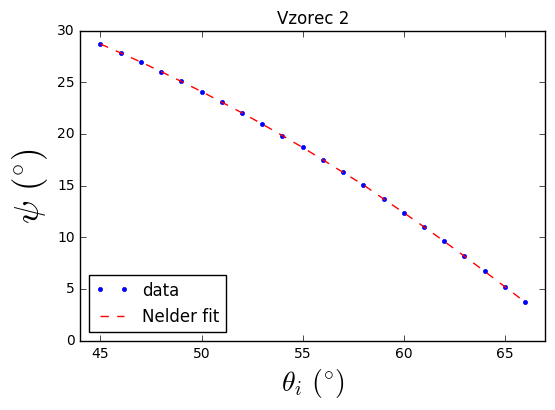

In [79]:
# plot results
plt.cla()
plt.plot(rad2deg(theta_data), rad2deg(psi_data),'b.', label='data')
#plt.plot(rad2deg(theta_data), final_leastsq, 'r-', label='leastsq')
plt.plot(rad2deg(theta_data), rad2deg(final_nelder), 'r--', label='Nelder fit')
plt.legend(loc='lower left')

plt.xlim(44,67)

#plt.setp(fig,lw=2.5)
plt.xlabel(r'$\theta_{i}$ $(^{\circ})$',size=20)
plt.ylabel(r'$\psi$ $(^{\circ})$',size=25,rotation=90)
plt.title('Vzorec 2')

plt.savefig("psi_fit_sample_2.pdf",bbox_inches='tight')

plt.show()